In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import shapely

import geopandas as gp

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
%matplotlib inline

In [54]:
def plot_polygons(geoms, ax, values=None, colormap='Set1', facecolor=None, edgecolor=None,
                            alpha=1.0, linewidth=1.0, **kwargs):
    """Makes a MatPlotLib PatchCollection out of Polygon and/or MultiPolygon geometries 
     Thanks to http://stackoverflow.com/a/33753927 and David Sullivan"""
    
    # init list to store 
    patches = []
    newvals = []
    
    for polynum in range(len(geoms)):                          # for  polygon # i
        poly = geoms.iloc[polynum]                              # find data.geometry[i] 
        if type(poly) != shapely.geometry.polygon.Polygon:     # if that is not a shapely Polygon object
            for currpoly in poly.geoms:                         # then for data.geometry[i].geoms
                a = np.asarray(currpoly.exterior)                  # make a an array of those exterior values and
                patches.append(Polygon(a))                           # append ato patches
                if values is not None:                               # if values, add value to newvals
                    newvals.append(values.iloc[polynum])
        else:
            a = np.asarray(poly.exterior)
            patches.append(Polygon(a))
            if values is not None:
                newvals.append(values.iloc[polynum])

    patches = PatchCollection(patches, 
                              facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, 
                              **kwargs)
    if values is not None:
        patches.set_array(np.asarray(newvals))
        patches.set_cmap(colormap)
        norm = matplotlib.colors.Normalize()
        norm.autoscale(newvals)
        patches.set_norm(norm)
    ax.add_collection(patches, autolim=True)
    ax.autoscale_view()
    return patches

In [37]:
# see which dir we're in since we need to access data
!pwd

/Users/jared/Desktop/geo187/Randomized_Election/code


## Read in data

Now, let's read in the data.

Our dataset, `election`, has informatino about every county in the United States.
For each county we possess informatin such as `votes`, `margin`, etc.

In [38]:
election = gp.read_file('../data/election-map.shp')

In [39]:
election.head(n=5)

,FID,dem,dempc,geometry,gop,goppc,grn,lib,margin,name,newstate,oth,population,state,una,votes
0,1001,5908,0.239569,"POLYGON ((892112.80012558 1115678.795392964, 8...",18110,0.734358,105,538,0.494789,Autauga,AL,0,54571,AL,0,24661
1,1003,18409,0.195653,"POLYGON ((780232.5698541742 947375.2080644479,...",72780,0.773515,453,2448,0.577862,Baldwin,AL,0,182265,AL,0,94090
2,1005,4848,0.466603,"POLYGON ((1026127.598653847 1057957.143773036,...",5431,0.522714,18,93,0.056112,Barbour,AL,0,27457,AL,0,10390
3,1007,1874,0.214220,"POLYGON ((845034.8675876737 1149437.158844963,...",6733,0.769662,17,124,0.555441,Bibb,AL,0,22915,AL,0,8748
4,1009,2150,0.084699,"POLYGON ((871035.6126721548 1287748.49965, 886...",22808,0.898519,89,337,0.813820,Blount,AL,0,57322,AL,0,25384


In [40]:
test= election.geometry[2].exterior

In [41]:
print type(test)

<class 'shapely.geometry.polygon.LinearRing'>


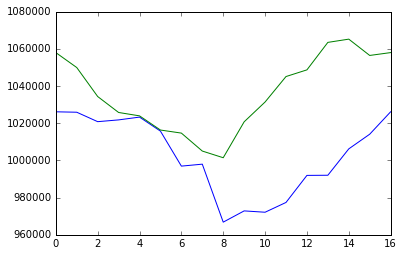

In [42]:
# below won't work because we're dealing with a polygon obect
plt.plot(test)

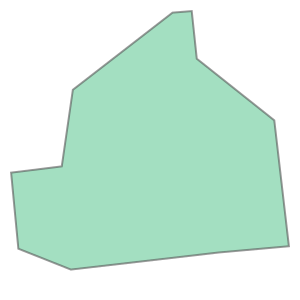

In [43]:
# instead, just type it in
election.geometry[3]

In [44]:
election['newstate'] = election.state
election.newstate

0       AL
1       AL
2       AL
3       AL
4       AL
5       AL
6       AL
7       AL
8       AL
9       AL
10      AL
11      AL
12      AL
13      AL
14      AL
15      AL
16      AL
17      AL
18      AL
19      AL
20      AL
21      AL
22      AL
23      AL
24      AL
25      AL
26      AL
27      AL
28      AL
29      AL
        ..
3062    WI
3063    WI
3064    WI
3065    WI
3066    WI
3067    WI
3068    WI
3069    WY
3070    WY
3071    WY
3072    WY
3073    WY
3074    WY
3075    WY
3076    WY
3077    WY
3078    WY
3079    WY
3080    WY
3081    WY
3082    WY
3083    WY
3084    WY
3085    WY
3086    WY
3087    WY
3088    WY
3089    WY
3090    WY
3091    WY
Name: newstate, dtype: object

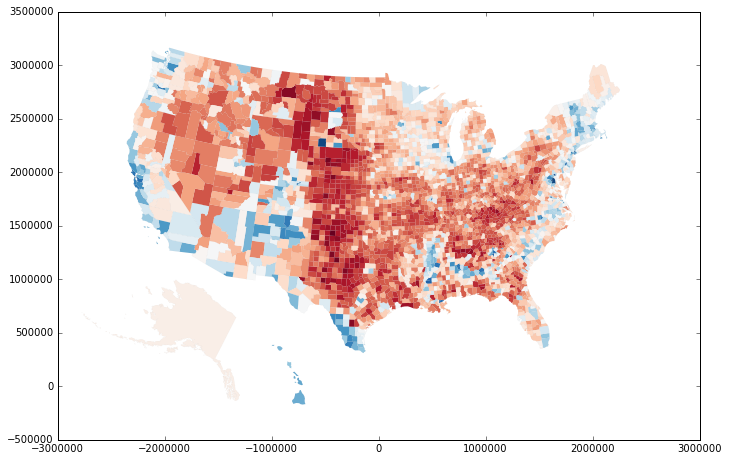

In [45]:
fig, ax = plt.subplots(figsize=(11.5,8))
ax.set_aspect('equal')
plot_polygons(ax=ax, geoms=election.geometry, linewidth=.01, values=election.goppc, colormap='RdBu_r')

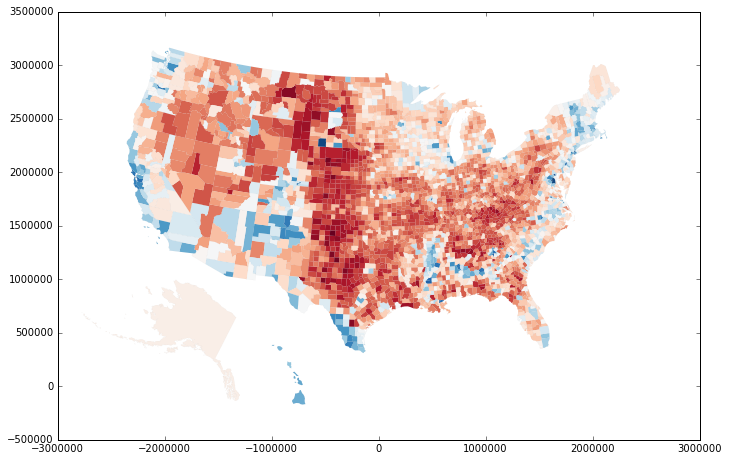

In [53]:
fig, ax = plt.subplots(figsize=(11.5,8))
ax.set_aspect('equal')
plot_polygons(ax=ax, geoms=election.geometry, linewidth=.01, values=election.goppc, colormap='RdBu_r')